In [1]:
## OS 
import os
import gc

## 
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
import io
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
from dask_ml.model_selection import train_test_split 
from server_no_HE import Server
from client_no_HE import Client
import datetime
import tenseal as ts
#### GLOBAL PARAMS ####
num_servers = 1
num_clients = 3
batch_size = 512
ratio_test_all = 0.2
np.float = np.float32
np.int =np.int32

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)

#### CLIENT NAME ####
active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

#### FILE INPUT ####
dir = "C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/" if os.name == 'nt' else "/mnt/c/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/"

input_files = [dir+f"parquet_f{index}" for index in range(len(active_clients_list))]
print("Input Files: ",input_files)

dfs = [dk.read_parquet(file) for file in input_files]
dfs = [df.drop(columns=['label']) for df in dfs]
# dfs = [df.sample(frac=0.1, random_state=42) for df in dfs]

#### FEATURE LEN & NUM CLASSES ####
value_count = len(dfs[0]['detailed-label'].value_counts().compute())
num_classes = num_classes = 1 if  value_count<=2  else value_count
features_len = len(dfs[1].columns) - 1
print(f"Classes Number {num_classes}\nFeature Len: {features_len}")

#### TRAIN TEST ####
train_dfs = []
val_dfs = []
test_dfs = []
for df in dfs:
    train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_test_df,     test_size=0.75, random_state=42)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

#### GENERATOR ####
def dask_to_tf_dataset(dask_df, batch_size, num_classes):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            
            X = batch.drop(columns='detailed-label').values.astype(np.float32)
            y = to_categorical(batch['detailed-label'].values.astype(np.int32), num_classes=num_classes) \
                if num_classes > 1 else batch['detailed-label'].values.astype(np.int32)
                
            del batch
            gc.collect()
            
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
            
    output_signature = ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.int32),
    ) if num_classes>1 else ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    
    gc.collect()
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

#### GENERATOR GET ####
train_gens = [dask_to_tf_dataset(train_df, batch_size, num_classes).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, num_classes).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, num_classes).repeat() for test_df in test_dfs]

stepsPerEpoch_Clients = [np.ceil(train_dfs[index].shape[0].compute())//(batch_size*10) for index in range(num_clients)]
stepsValidate_Clients = [step//16 for step in stepsPerEpoch_Clients]  # [int(np.ceil(val_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]
stepsTest_Clients = [(step*3) for step in stepsValidate_Clients]  #[int(np.ceil(test_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]
print(stepsPerEpoch_Clients)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list, num_classes= num_classes)
                 for clientID, client_name in enumerate(active_clients_list)}

temp_dir_log = clientObjects['client_0'].get_temp_dir()

for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
agents_dict['client'] = clientObjects
for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)


server = agents_dict['server']['server_0']

# Giải phóng DataFrame sau khi không cần thiết
del train_dfs, val_dfs, test_dfs, agents_dict
gc.collect()

server.InitLoop()
tf.keras.backend.clear_session()
gc.collect()
server.final_statistics()

['server_0']
['client_0', 'client_1', 'client_2']
Input Files:  ['C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f0', 'C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f1', 'C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f2']
Classes Number 1
Feature Len: 23
[np.int64(7156), np.int64(4001), np.int64(2608)]
Num classe: 1
Loss Fucntion: binary_crossentropy
Activation Function: sigmoid
Num classe: 1
Loss Fucntion: binary_crossentropy
Activation Function: sigmoid
Num classe: 1
Loss Fucntion: binary_crossentropy
Activation Function: sigmoid
Federated_Learning_Log/Month06-Day09-18h-48p
Train steps:  7156
Val steps:  447
Test steps:  1341
Train steps:  4001
Val steps:  250
Test steps:  750
Train steps:  2608
Val steps:  163
Test steps:  489
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/4
Epoch 1/4
Epoch 1/4
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 115s 43ms/step - accuracy: 0.5488 - loss: 5.9595 - val_accuracy: 0.

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/4
Epoch 1/4
Epoch 1/4
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 118s 44ms/step - accuracy: 0.8174 - loss: 0.4766 - val_accuracy: 0.9836 - val_loss: 0.2206
Epoch 2/4
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 181s 44ms/step - accuracy: 0.8648 - loss: 0.4348 - val_accuracy: 0.9690 - val_loss: 0.1991
Epoch 2/4
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 130s 50ms/step - accuracy: 0.9756 - loss: 0.2320 - val_accuracy: 0.9838 - val_loss: 0.1693
5437/7156 ━━━━━━━━━━━━━━━━━━━━ 1:17 45ms/step - accuracy: 0.8821 - loss: 0.3496Epoch 3/4
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 355s 49ms/step - accuracy: 0.8978 - loss: 0.3229 - val_accuracy: 0.9891 - val_loss: 0.1268
Epoch 2/4
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 146s 56ms/step - accuracy: 0.9807 - loss: 0.1911 - val_accuracy: 0.9841 - val_loss: 0.1476
Epoch 4/4
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 228s 57ms/step - accuracy: 0.9639 - loss: 0.2203 - val_accuracy: 0.9696 - val_loss: 0.1591
Epoch 3/4
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 148s 57ms/step - accuracy: 0.9825 - loss: 0.1674 - val_accuracy: 0.9

ResourceExhaustedError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
MemoryError: Unable to allocate 20.9 MiB for an array with shape (10, 273412) and data type int64
Traceback (most recent call last):

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\hoang\AppData\Local\Temp\ipykernel_21392\3531039140.py", line 70, in generator
    batch = batch.compute()
            ^^^^^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\base.py", line 374, in compute
    (result,) = compute(self, traverse=False, **kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\base.py", line 662, in compute
    results = schedule(dsk, keys, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\dask_expr\_expr.py", line 1740, in pd_split
    return df.assign(_split=index)
           ^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py", line 796, in copy
    values = values.copy()
             ^^^^^^^^^^^^^

numpy._core._exceptions._ArrayMemoryError: Unable to allocate 20.9 MiB for an array with shape (10, 273412) and data type int64


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_2261291]

In [1]:
## OS 
import os
import gc

## 
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
import io
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
from dask_ml.model_selection import train_test_split 
from server_no_HE import Server
from client_no_HE import Client
import datetime
import tenseal as ts
#### GLOBAL PARAMS ####
num_servers = 1
num_clients = 3
batch_size = 512
ratio_test_all = 0.2
np.float = np.float32
np.int =np.int32

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)

#### CLIENT NAME ####
active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

#### FILE INPUT ####
dir = "C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/" if os.name == 'nt' else "/mnt/c/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/"

input_files = [dir+f"parquet_f{index}" for index in range(len(active_clients_list))]
print("Input Files: ",input_files)

dfs = [dk.read_parquet(file) for file in input_files]
dfs = [df.drop(columns=['label']) for df in dfs]
# dfs = [df.sample(frac=0.1, random_state=42) for df in dfs]

#### FEATURE LEN & NUM CLASSES ####
value_count = len(dfs[0]['detailed-label'].value_counts().compute())
num_classes = num_classes = 1 if  value_count<=2  else value_count
features_len = len(dfs[1].columns) - 1
print(f"Classes Number {num_classes}\nFeature Len: {features_len}")

#### TRAIN TEST ####
train_dfs = []
val_dfs = []
test_dfs = []
for df in dfs:
    train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_test_df,     test_size=0.75, random_state=42)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

#### GENERATOR ####
def dask_to_tf_dataset(dask_df, batch_size, num_classes):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            
            X = batch.drop(columns='detailed-label').values.astype(np.float32)
            y = to_categorical(batch['detailed-label'].values.astype(np.int32), num_classes=num_classes) \
                if num_classes > 1 else batch['detailed-label'].values.astype(np.int32)
                
            del batch
            gc.collect()
            
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
            
    output_signature = ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.int32),
    ) if num_classes>1 else ( 
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    
    gc.collect()
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

#### GENERATOR GET ####
train_gens = [dask_to_tf_dataset(train_df, batch_size, num_classes).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, num_classes).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, num_classes).repeat() for test_df in test_dfs]

stepsPerEpoch_Clients = [np.ceil(train_dfs[index].shape[0].compute()) // (batch_size*10) for index in range(num_clients)]
stepsValidate_Clients = [step//16 for step in stepsPerEpoch_Clients]  # [int(np.ceil(val_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]
stepsTest_Clients = [(step*3) for step in stepsValidate_Clients]  #[int(np.ceil(test_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]

['server_0']
['client_0', 'client_1', 'client_2']
Input Files:  ['C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f0', 'C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f1', 'C:/Users/hoang/FileCSV_DACN_2025/nonIID_fl_IoT23/parquet_f2']
Classes Number 1
Feature Len: 23


In [3]:
from tensorflow.keras.models import load_model
#tempdirs = [f"federated_learning_log/Month05-Day27-15h-12p/client_{i}_log/" for i in range(len(active_clients_list))]

num_servers = 1
num_clients = 3
batch_size = 512
#### CLIENT NAME ####
active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)


temp_dir_log = "Federated_Learning_Log/Month06-Day09-18h-48p"
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

model_names =[f"global_model_iter_{i+1}.keras" for i in range(4)]
print(model_names)
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models['client_0'])

['server_0']
['client_0', 'client_1', 'client_2']
['global_model_iter_1.keras', 'global_model_iter_2.keras', 'global_model_iter_3.keras', 'global_model_iter_4.keras']
[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


690018
<Sequential name=sequential, built=True>
21564/21564 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
<Sequential name=sequential, built=True>
21564/21564 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
<Sequential name=sequential, built=True>
21564/21564 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
<Sequential name=sequential, built=True>
21564/21564 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
Precision Score:  [0.9752372976850583, 0.9871326925387911, 0.9950497287113926, 0.9997692964449854]
Recall Score:  [0.5755474114357252, 1.0, 1.0, 1.0]
F1 Score:  [0.7238855257174067, 0.9935246863435329, 0.9975187228581993, 0.9998846349149251]


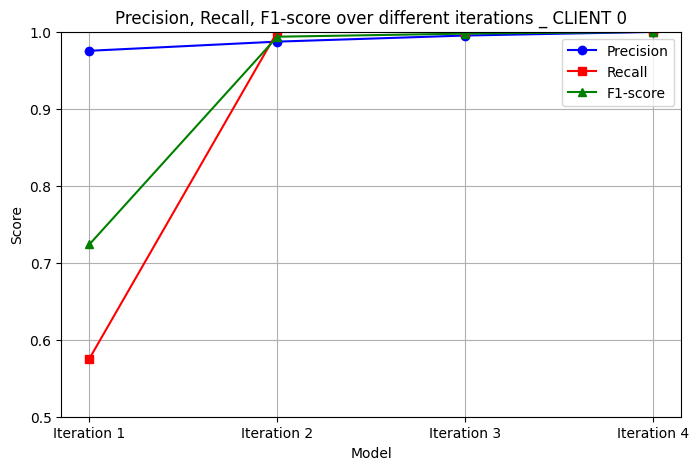

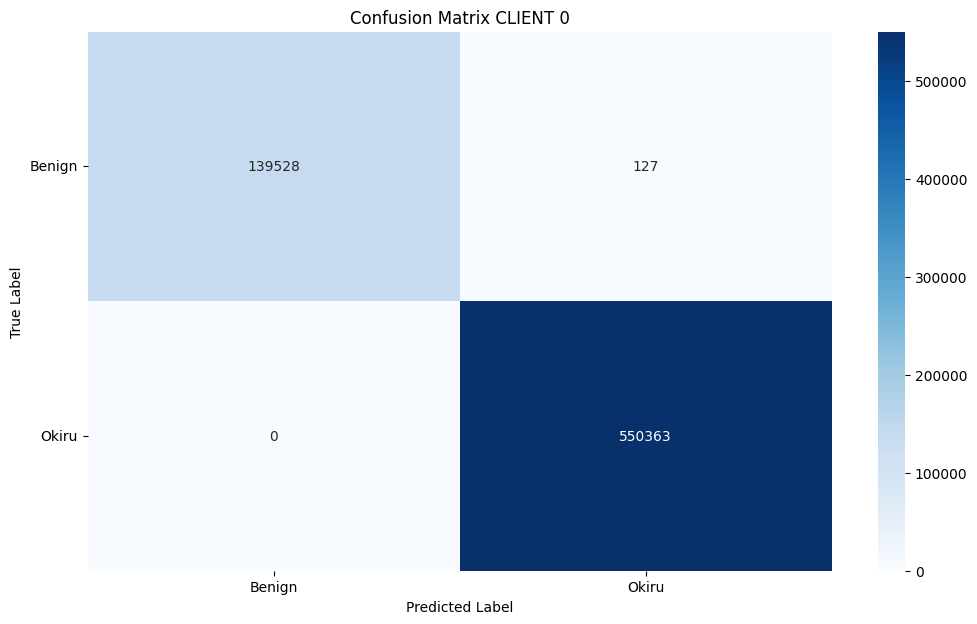

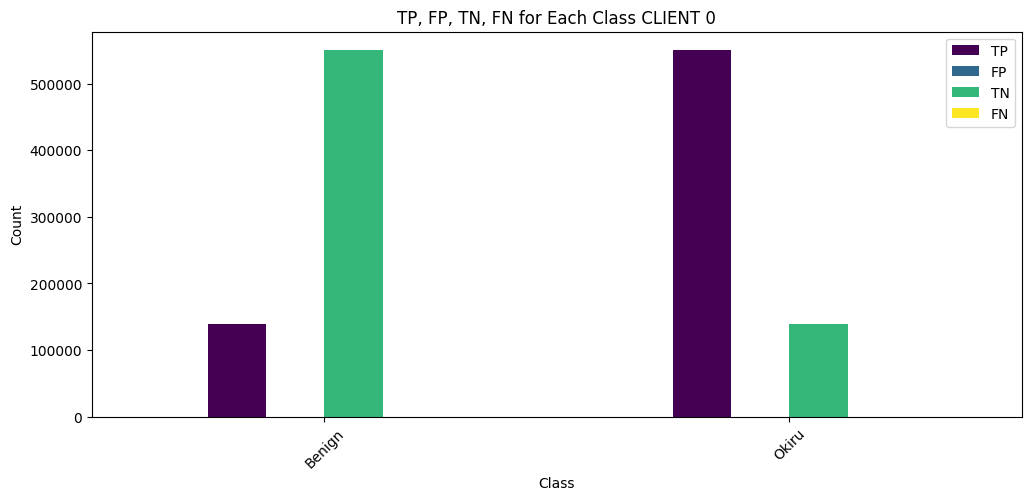

In [4]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['Benign', 'Okiru']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.show()

metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

386408
<Sequential name=sequential_1, built=True>
12076/12076 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_1, built=True>
12076/12076 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_1, built=True>
12076/12076 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
12076/12076 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Precision Score:  [0.6457839290590551, 0.925879404796697, 0.9304094078832262, 0.9968868000321363]
Recall Score:  [0.905304938246731, 1.0, 1.0, 1.0]
F1 Score:  [0.753833506693957, 0.9615133766845969, 0.9639503455419425, 0.9984409732350308]


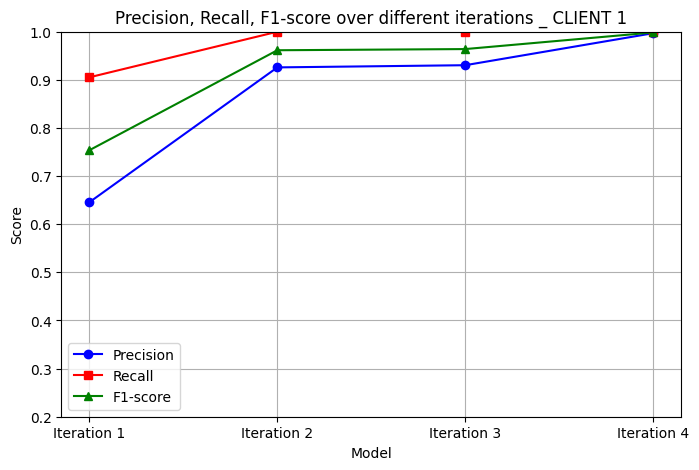

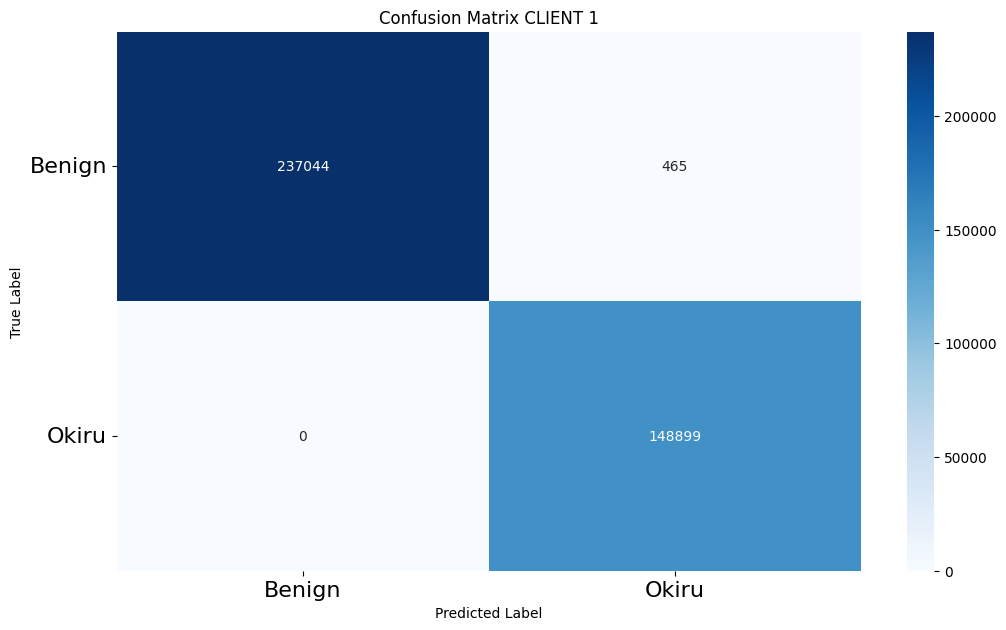

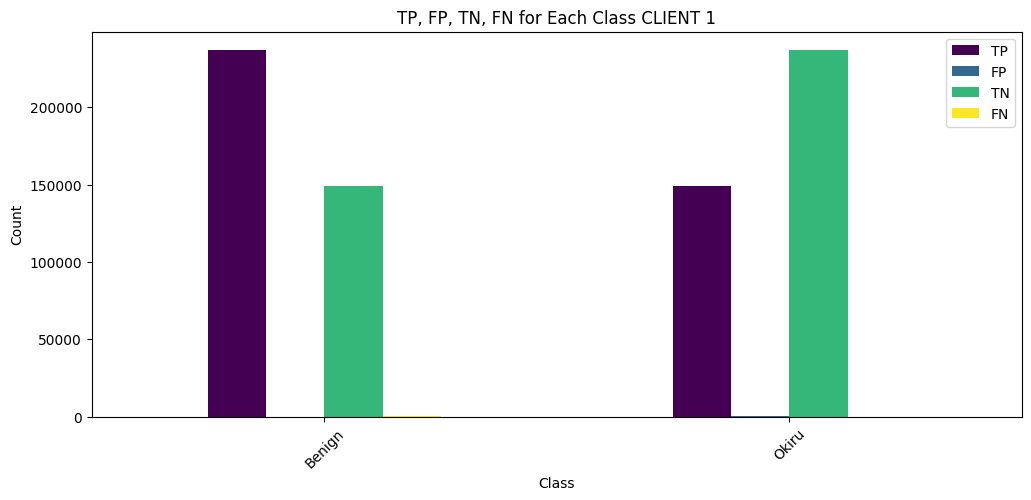

In [5]:
#Client 1

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[1].take(stepsTest_Clients[1]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_1'][iteration])
    y_pred_pre = models['client_1'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0.2, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['Benign', 'Okiru']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360, fontsize = 16)
plt.xticks(fontsize=16)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

In [10]:
# CLIENT 2


precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))

251606
<Sequential name=sequential_2, built=True>
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
<Sequential name=sequential_2, built=True>
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
<Sequential name=sequential_2, built=True>
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
<Sequential name=sequential_2, built=True>
7863/7863 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


Số mẫu test client 2:  2503680
Precision Score:  [0.7247567122723999, 0.978114674441205, 0.9790062864416295, 0.9909030047650927]
Recall Score:  [1.0, 1.0, 1.0, 1.0]
F1 Score:  [0.8404161666575214, 0.988936270560261, 0.9893917903635776, 0.9954307190188904]


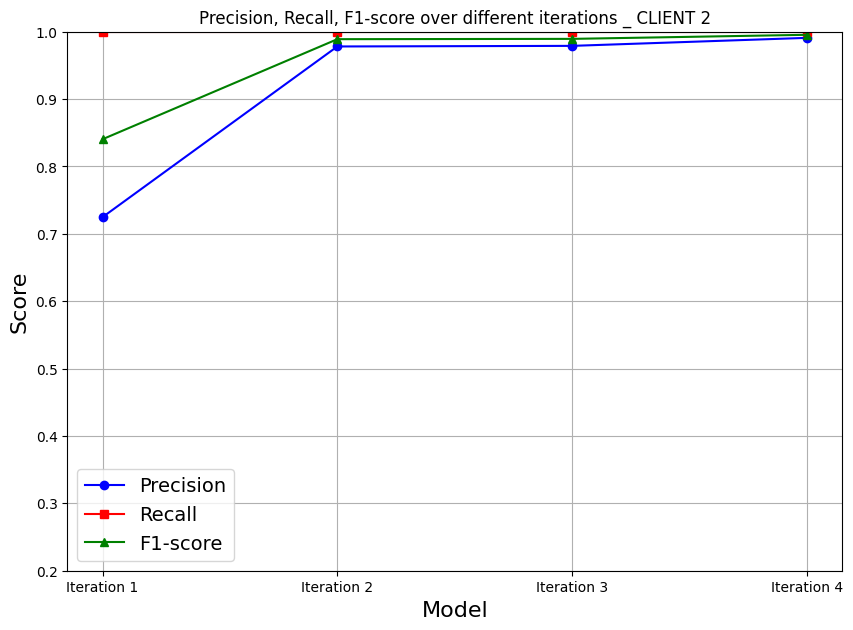

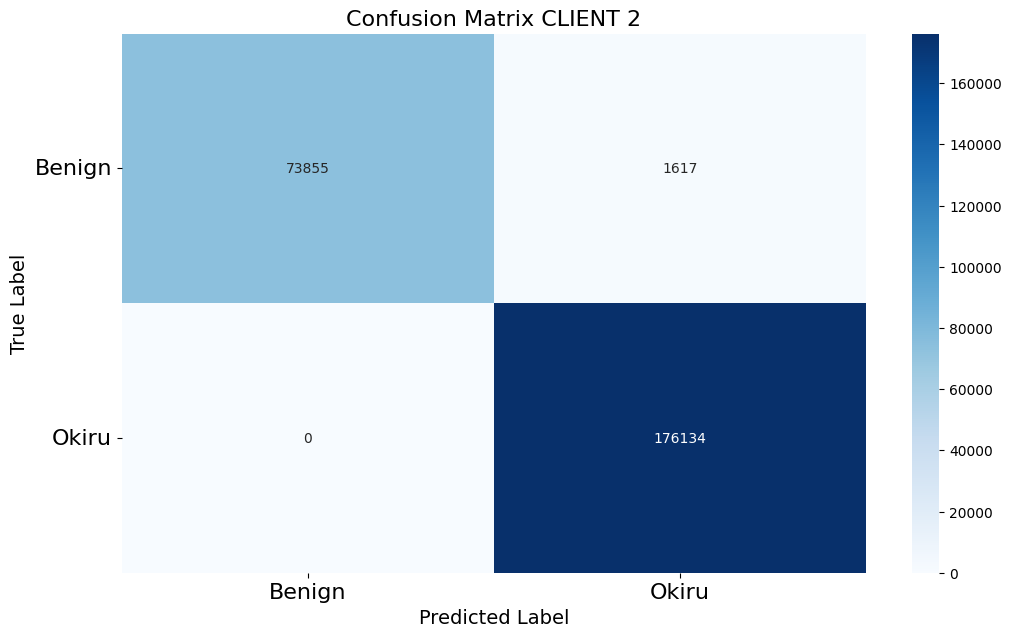

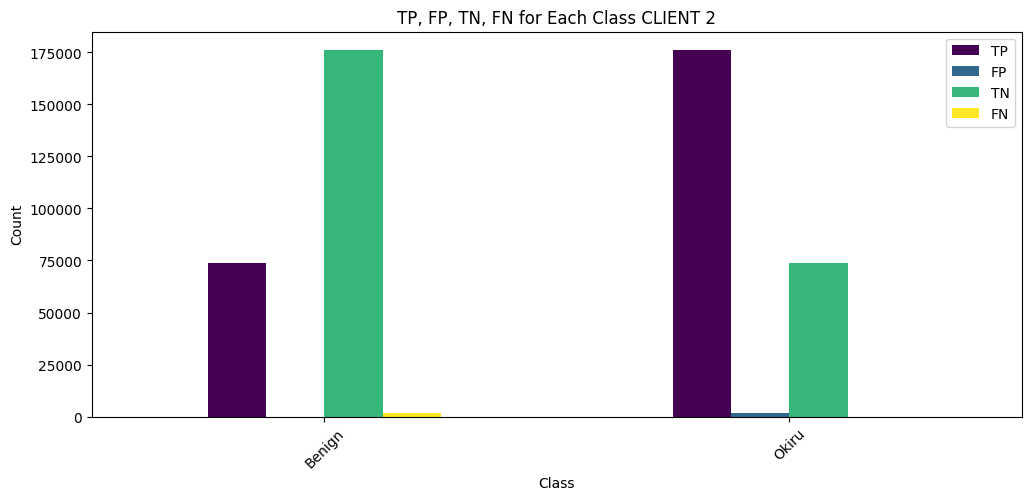

In [11]:
print("Số mẫu test client 2: ", stepsTest_Clients[2]*10*512)
#Client 2
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model",fontsize = 16)
plt.ylabel("Score",fontsize = 16)
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend(fontsize = 14)
plt.ylim(0.2, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['Benign', 'Okiru']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360, fontsize = 16)
plt.xticks(fontsize=16)
# Thêm nhãn
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize =14)
plt.title("Confusion Matrix CLIENT 2", fontsize =16)

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

Federated_Learning_Log/Month06-Day09-18h-48p/client_0_log/Iteration_1.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_0_log/Iteration_2.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_0_log/Iteration_3.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_0_log/Iteration_4.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_1_log/Iteration_1.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_1_log/Iteration_2.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_1_log/Iteration_3.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_1_log/Iteration_4.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_2_log/Iteration_1.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_2_log/Iteration_2.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_2_log/Iteration_3.csv
Federated_Learning_Log/Month06-Day09-18h-48p/client_2_log/Iteration_4.csv


C:\Users\hoang\AppData\Local\Temp\ipykernel_20328\727563285.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, log_df['val_accuracy'], 'b-', label='Validation Accuracy', color='orange')
C:\Users\hoang\AppData\Local\Temp\ipykernel_20328\727563285.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss', color='green')
C:\Users\hoang\AppData\Local\Temp\ipykernel_20328\727563285.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.
  plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss', color='red')
C:\Users\hoang\AppData\Local\Temp\ipykernel_20328\727563285.py:30: UserW

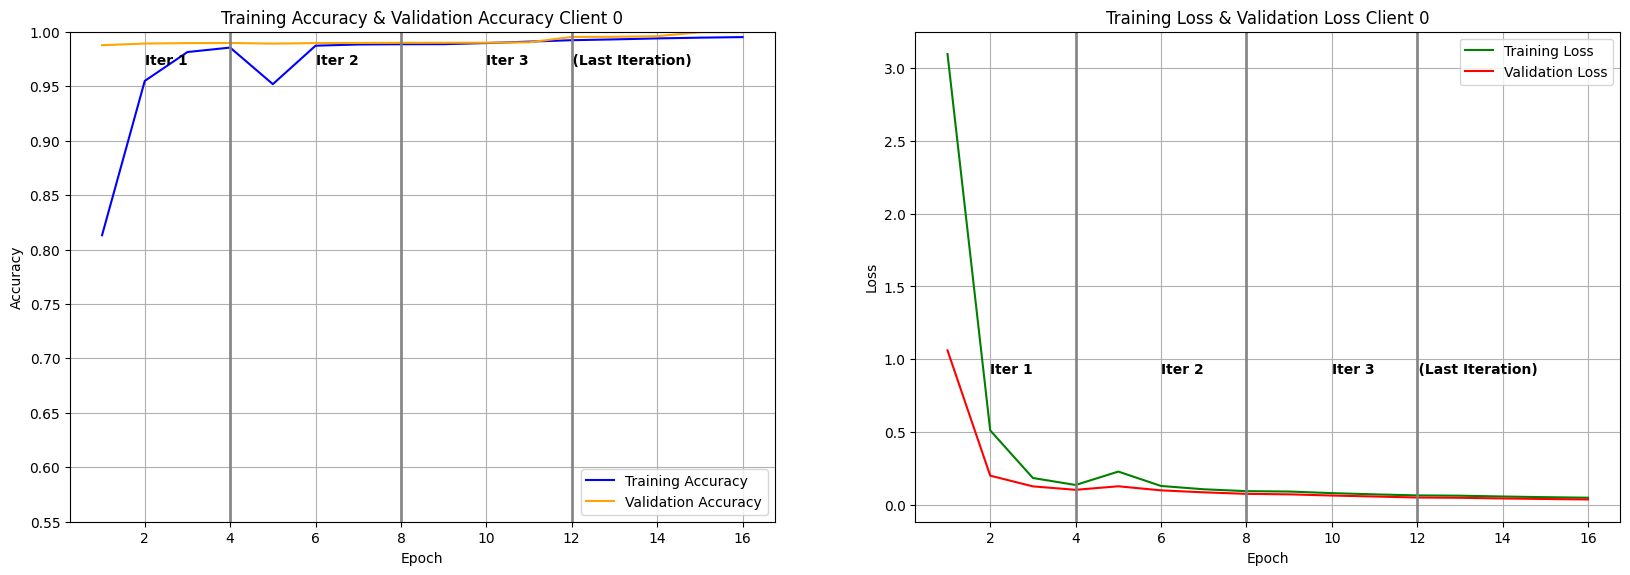

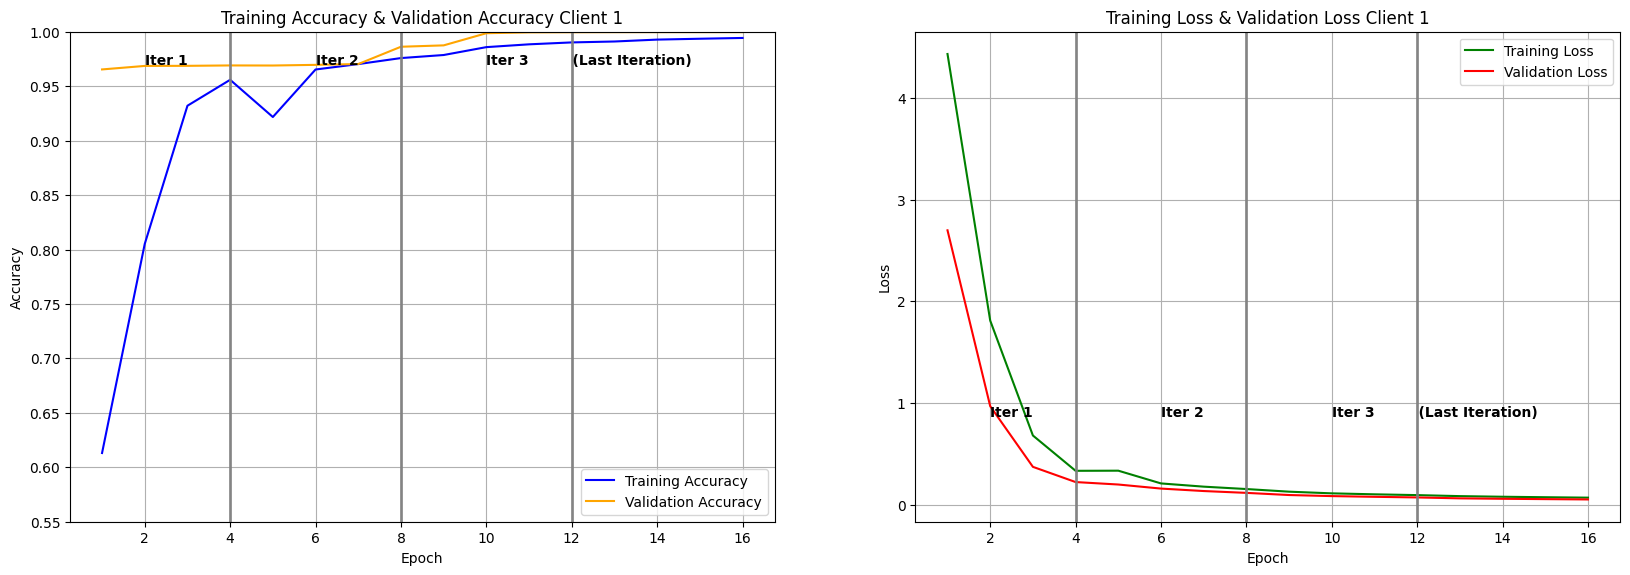

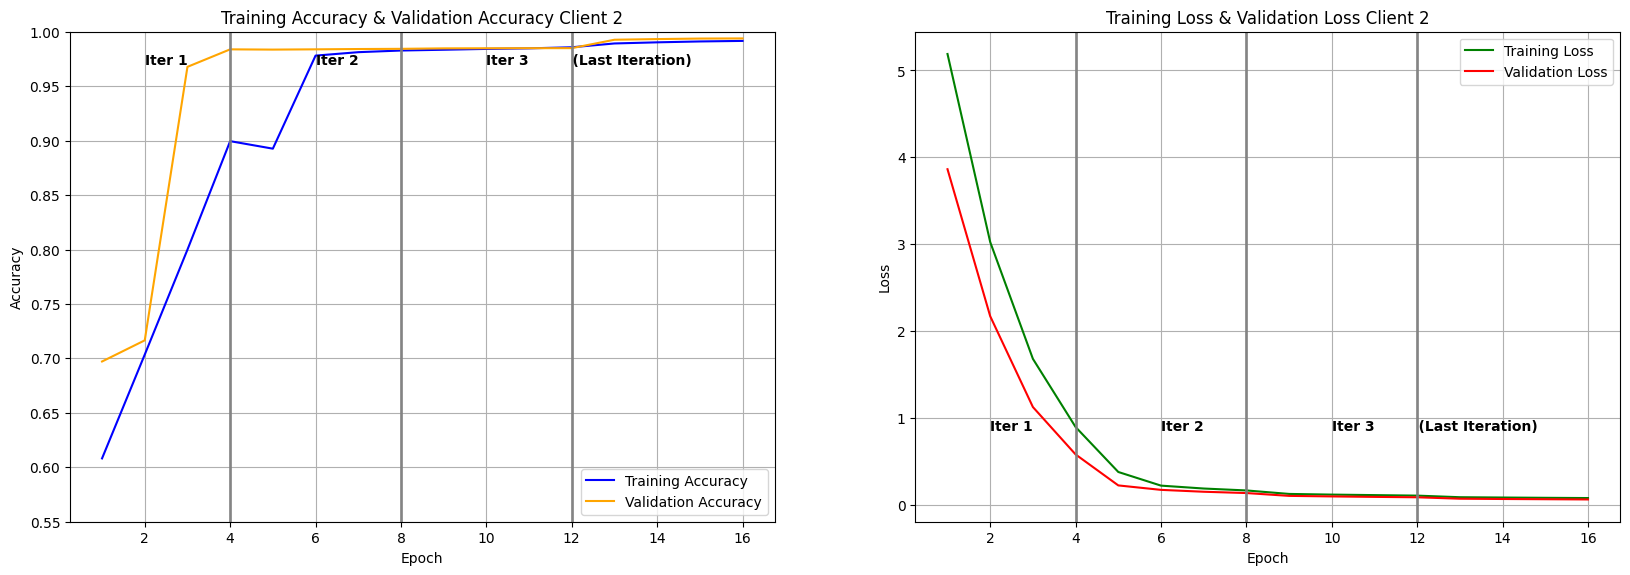

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

tempdirs= [f"Federated_Learning_Log/Month06-Day09-18h-48p/client_{index}_log/" for index in range (3)]
log_names = [f"Iteration_{i+1}.csv" for i in range(4)]

# Vẽ biểu đồ cho từng client
for i in range(3):
    # Kết hợp dữ liệu từ các file log
    all_logs = []
    for log_name in log_names:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        print(file_path)
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    # Kết hợp dữ liệu từ các file log
    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)  # Tổng cộng 20 epoch (4 iterations x 5 epochs)

    plt.figure(figsize=(20, 14))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, log_df['val_accuracy'], 'b-', label='Validation Accuracy', color='orange')
    # Thêm đường kẻ dọc tại epoch 5, 10, 15
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 4, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:  
            plt.text(iter_idx * 4 - 2, 0.98, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:  # Iter 4
            plt.text(iter_idx * 4 - 2, 0.98, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
            
    plt.title(f'Training Accuracy & Validation Accuracy Client {i}', )
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.55, 1.0)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss', color='green')
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss', color='red')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 4, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:  
            plt.text(iter_idx * 4 - 2, 0.98, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:  # Iter 4
            plt.text(iter_idx * 4 - 2, 0.98, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss & Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()